# Inicialização

In [1]:
from collections import Counter
from itertools import product
import re
import time
import unicodedata

import yaml
import numpy as np
import pandas as pd
from sklearn.decomposition.nmf import ProjectedGradientNMF
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import TweetTokenizer

In [2]:
from bokeh.models import ColumnDataSource
import bokeh.plotting


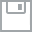
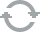
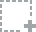
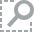
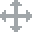
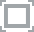
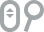
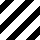
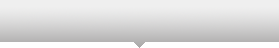
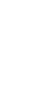
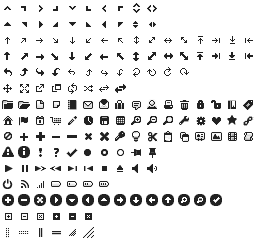
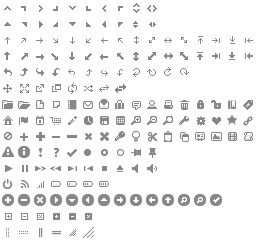
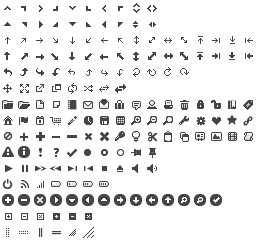
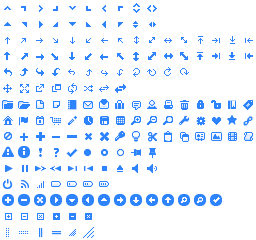
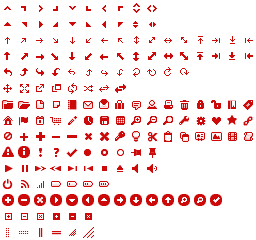
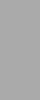
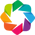
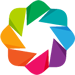

In [3]:
bokeh.plotting.output_notebook()

# Wordcloud

In [347]:
from wordcloud import WordCloud

def plot_wordcloud(words, ax=None, **kwargs):
    
    default_kwargs = {
        "font_path": "impact.ttf",
        "background_color": "white",
        "max_font_size": 70,
        "prefer_horizontal": 1.0,
        "width": 700,
        "height": 300,
    }
    
    default_kwargs.update(kwargs)
    wordcloud = WordCloud(**default_kwargs)
    
    generated_wordcloud = wordcloud.generate_from_frequencies(words)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.set_aspect('equal')
    ax.imshow(generated_wordcloud)
    ax.axis("off")
    return generated_wordcloud

# Tokenização

In [7]:
def doc_to_tweet(docs):
    for doc in docs:
        text = doc['_source'].get('text', '')
        if text:
            yield text

In [357]:
TOKENIZER = TweetTokenizer()
RE_JAJA = re.compile('^[jae]{2,}$')

def filter_tokens(tokens):
    
    for token in tokens:
        if RE_JAJA.match(token.lower()):
            yield "jaja"
        else:
            yield token

def tokenize_tweets(tweets):
    tokenizer = TOKENIZER
    for tweet in tweets:
        # Perform normalization of unicode characters
        #tweet = unicodedata.normalize("NFC", tweet)
        tweet = ''.join(unicodedata.normalize('NFD', x)[0] for x in tweet)

        tokens = tokenizer.tokenize(tweet)
  
        yield list(filter_tokens(tokens))

In [356]:
query = yaml.safe_load("""
query:
    filtered:
        filter:
            bool:
                must:
                - term:
                    user: tuenti
        query:
            query_string:
                query: murcia
_source:
    include:
    - user_info.screen_name
    - created_at
    - text
    - id
""")

docs = scan(es_conn, index="twitter", doc_type="tweet", query=query, size=1000)
docs_df_all = pd.DataFrame.from_dict(
    (
        {
            "twitter_id": doc["_source"]["id"],
            "screen_name": doc["_source"]["user_info"]["screen_name"],
            "created_at": pd.to_datetime(doc["_source"]["created_at"]),
            "text": doc["_source"].get("text","")
        } for doc in docs),
    orient="columns"
)

In [358]:
# Tokenize
docs_df_all['tokenized'] = pd.Series(tokenize_tweets(docs_df_all['text'].values), index=docs_df_all.index)

In [383]:
docs_df.to_pickle('tweets_tuenti_tokenized.p')

In [359]:
docs_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 5 columns):
created_at     194 non-null datetime64[ns]
screen_name    194 non-null object
text           194 non-null object
twitter_id     194 non-null object
tokenized      194 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 9.1+ KB


In [100]:
docs_df_all.head(3)

created_at    screen_name  \
0 2015-10-18 13:22:00   Fruta_OnFire   
1 2015-10-18 11:21:04  Gaticodefelpa   
2 2015-10-17 22:15:18    EliotGuirao   

                                                text          twitter_id  \
0  RT @PizzaParaComer: Thypical 2012 tuenti pics....  655735581671104512   
1  Compartir videos de mierda y frases tuenti sí....  655705149231493124   
2               Tengo mas abandonao esto q el tuenti  655507403203563520   

                                           tokenized  
0  [RT, @PizzaParaComer, :, Thypical, 2012, tuent...  
1  [Compartir, videos, de, mierda, y, frases, tue...  
2       [Tengo, mas, abandonao, esto, q, el, tuenti]

In [360]:

docs_df = docs_df_all[docs_df_all['tokenized'].apply(lambda x: x and (len(set(x).intersection(wordlist)) > 0))]

In [361]:
wordlist_set = set(wordlist)

In [362]:
wordlist_set.in

SyntaxError: invalid syntax (<ipython-input-362-3e6b4b4b3f9d>, line 1)

# Montagem da matriz de documentos

In [19]:
wordlist = pd.read_pickle('wordlist.p')

In [363]:
wordlist_indices = dict(tuple(reversed(x)) for x in enumerate(wordlist))

In [364]:
doc_mat = np.zeros((docs_df.shape[0], len(wordlist)))

In [365]:
for idx_row, tokens in enumerate(docs_df['tokenized'].values):
    for token in tokens:
        token = token.lower()
        if token not in wordlist_indices:
            continue
            
        idx_token = wordlist_indices[token]
        doc_mat[idx_row, idx_token] = 1.0

In [366]:
doc_mat_norm = normalize(doc_mat)

In [367]:
S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001

In [368]:
S.shape

(833, 833)

In [369]:
D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])

In [370]:
Y = np.dot(D, doc_mat.T)

In [371]:
Y.shape

(833, 169)

# Cálculo da NMF

In [372]:
def edges_sum(cond_1, cond_2, S):
    nodes_1 = np.where(cond_1)[0]
    nodes_2 = np.where(cond_2)[0]
    
    indices = product(nodes_1, nodes_2)
    return np.sum(S[idx] for idx in indices)


def n_cut(mat_U, mat_S):
    
    term_clusters = mat_U.argmax(axis=1)
    
    n_k = mat_U.shape[1]
    
    result = 0.0
    for idx_k in range(n_k):
        
        cond_g_k = term_clusters == idx_k
        num = edges_sum(cond_g_k, ~cond_g_k, mat_S)
        den = edges_sum(cond_g_k,  cond_g_k, mat_S) + num
        
        result += num/den
        
    return 0.5 * result
    

In [373]:
models = {}

source = ColumnDataSource(data={"x": [0], "y": [0]})

plot = bokeh.plotting.figure(title="Ncut", plot_height=500, plot_width=900)
plot.line(source.data['x'], source.data['y'], color="#2222aa", line_width=2, source=source)
plot.circle(source.data['x'], source.data['y'], color="#2222aa", fill_color="white", size=8, source=source)
bokeh.plotting.show(plot)

In [190]:
import random

In [191]:
num_topics = list(range(5, 50))
random.shuffle(num_topics)
random.shuffle(num_topics)
random.shuffle(num_topics)

In [374]:
for k in [10,]:
    
    start_time = time.time()
    model = ProjectedGradientNMF(n_components=k, init="nndsvda", max_iter=1000)
    V_T = model.fit_transform(Y.T)
    U_T = model.components_
    n_cut_val = n_cut(U_T.T, S)
    
    models[k] = {
        "model": model,
        "V_T": V_T,
        "n_cut": n_cut_val,
    }
    
    end_time = time.time()
    
    #print("%d: %f" %(k, end_time - start_time))
    
    source.data['x'] = sorted(models.keys())
    source.data['y'] = [models[x]["n_cut"]/x for x in source.data['x']]
    source.push_notebook()

In [386]:
pd.to_pickle(models, 'tuenti_models.p')

In [375]:
weights = models[10]['model'].components_.reshape((-1, ))

In [350]:
weights.sort()

In [351]:
weights = weights / weights[weights >= 0.01][0]

In [352]:
weights.astype('int')

array([ 0,  0,  0, ..., 80, 80, 80])

In [376]:
def get_terms(data, wordlist):
    components = data['model'].components_
    words = np.argsort(-1*components, axis=1)[:,:10]
    np_wordlist = np.array(wordlist)
    
    return np_wordlist[words].tolist()

def print_terms(data, wordlist):
    terms = get_terms(data, wordlist)
    
    for idx_topic, terms_topic in enumerate(terms):
        print("%3d: %s" % (idx_topic, " ".join(terms_topic)))
        
def get_tweets(data, cluster, tweets):
    clusters = np.argmax(data['V_T'], axis=1)
    cluster_tweets = tweets[clusters == cluster]
    return cluster_tweets

In [323]:
from IPython.display import display

In [328]:
def plot_topic_wordclouds(data, wordlist):
    
    components = data['model'].components_
    sorted_components = np.sort(-1*components)*-1
    word_idxs = np.argsort(-1*components, axis=1)[:,:50]
    words = np.array(wordlist)[word_idxs]
    weights = sorted_components[:,:50]
    
    # Find minimum weight that is still greater than 0.01
    all_weights = weights.reshape((-1,))
    all_weights.sort()
    min_weight = all_weights[all_weights >= 0.01][0]
    weights = weights / min_weight
    weights = weights.round().astype('int')
    
    for idx_topic in range(components.shape[0]):
        
        topic_terms = words[idx_topic, :].tolist()
        topic_weights = weights[idx_topic, :].tolist()
        topic_words = list(zip(topic_terms, topic_weights))
        topic_words.sort(key=lambda x:x[1], reverse=True)
        print(idx_topic)
        
        fig, ax = plt.subplots(figsize=(12,6))
        plot_wordcloud(topic_words, ax=ax)
        display(fig)

0


/home/felipefg/.virtualenvs/analysis_py34/lib/python3.4/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


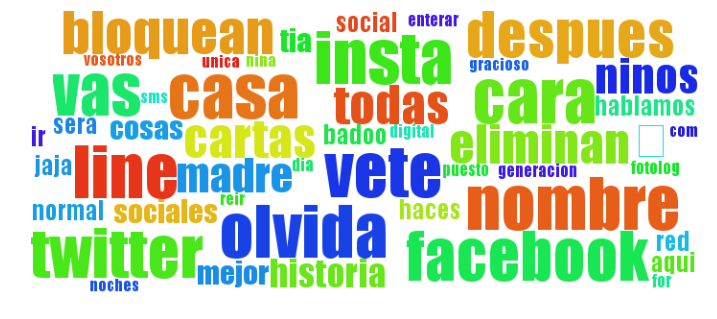

1


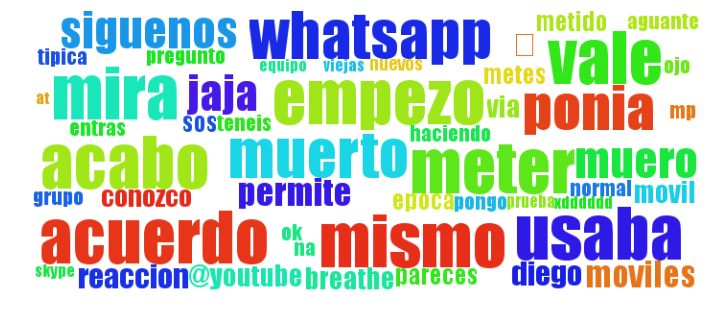

2


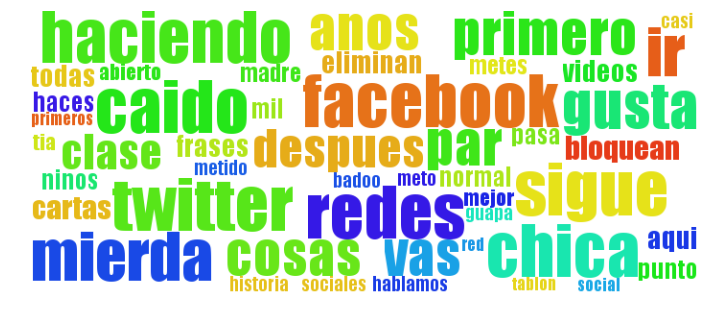

3


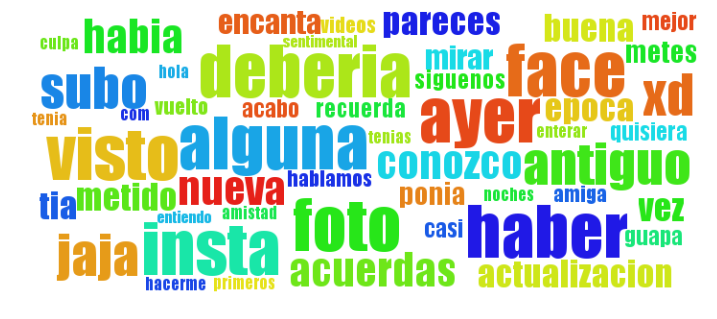

4


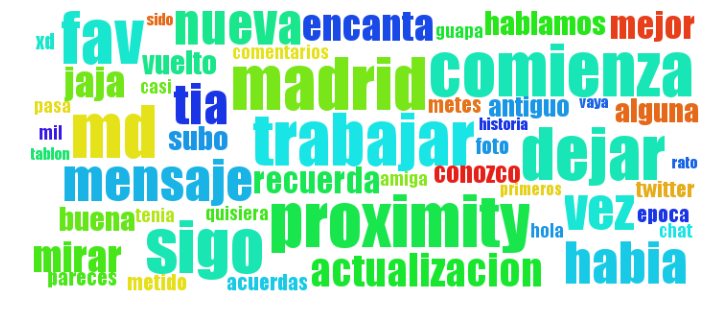

5


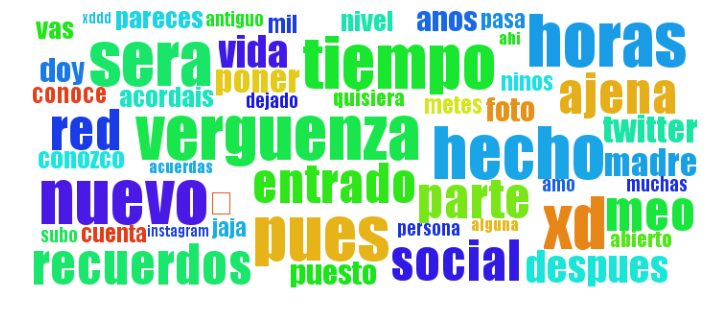

6


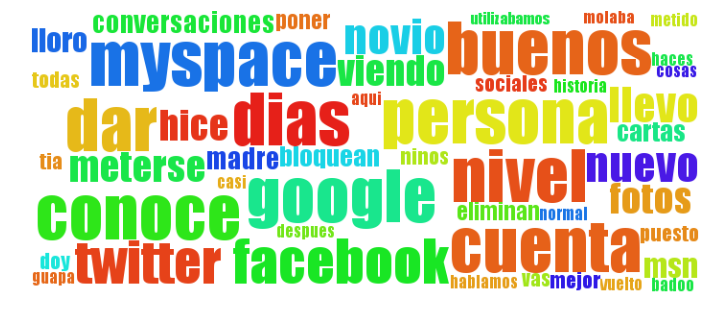

7


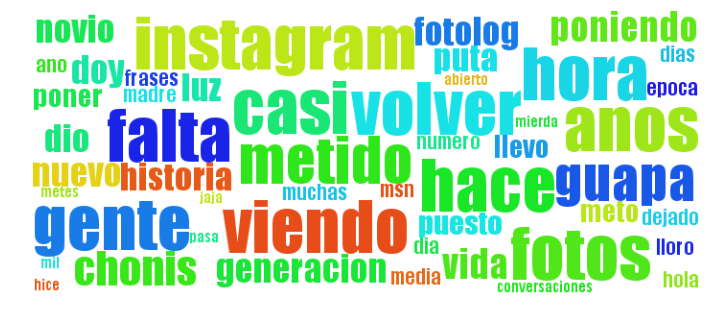

8


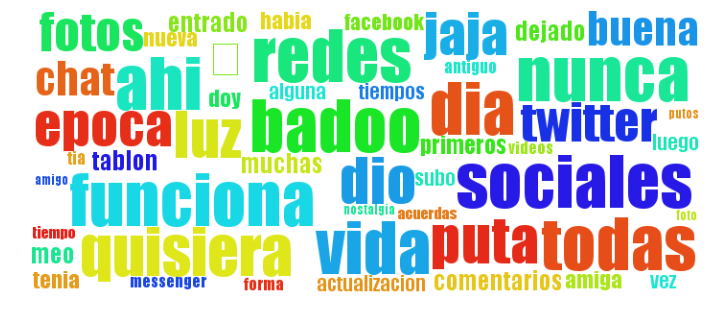

9


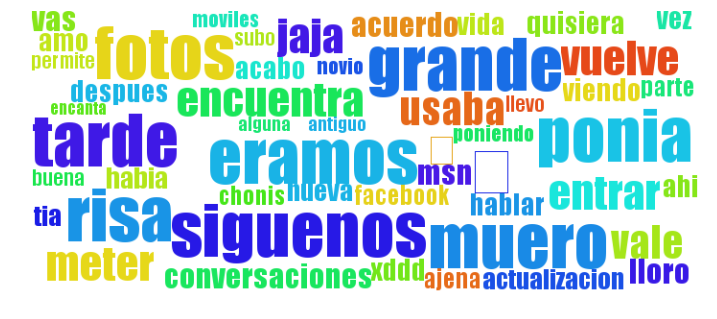

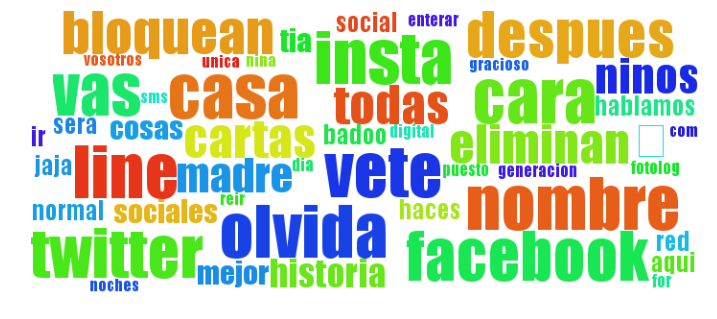

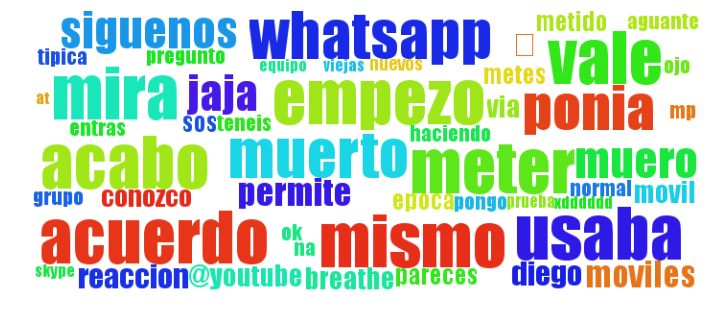

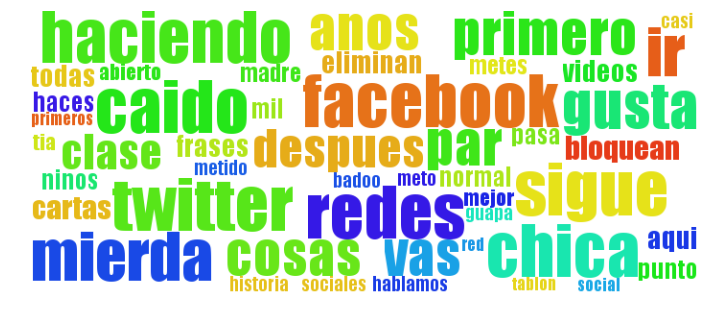

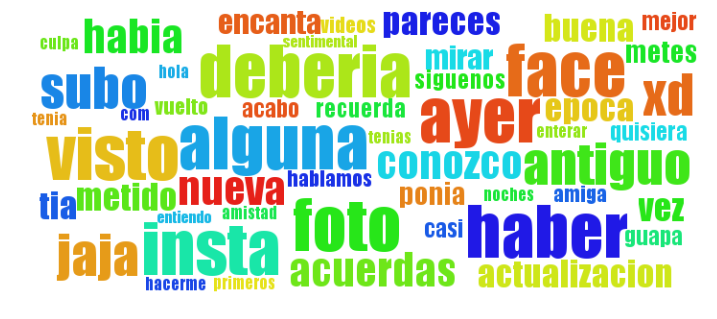

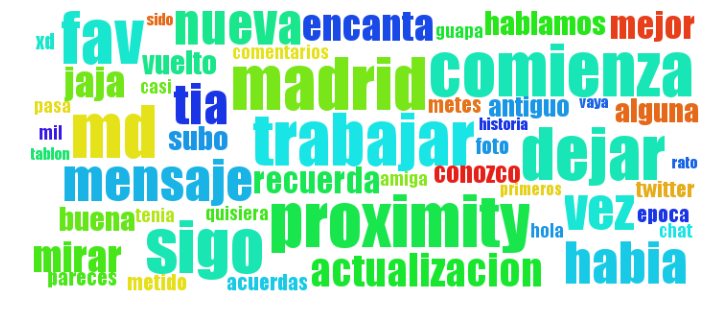

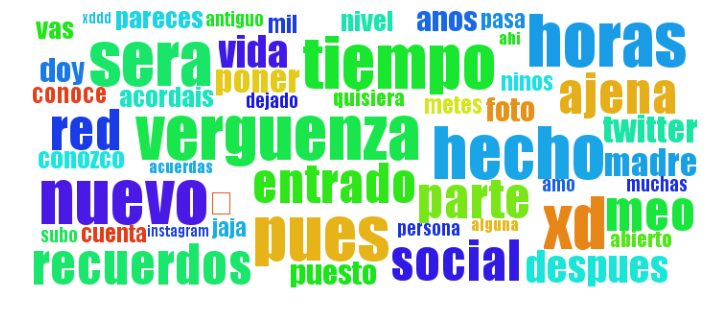

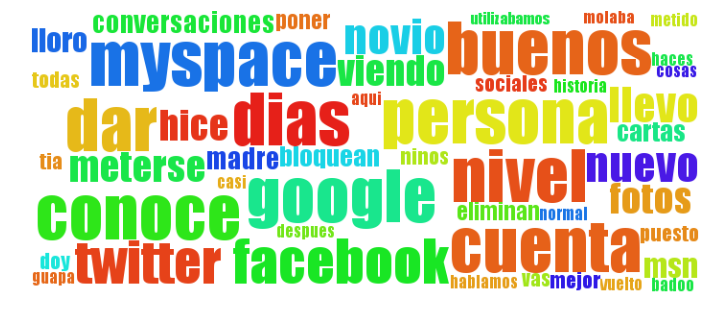

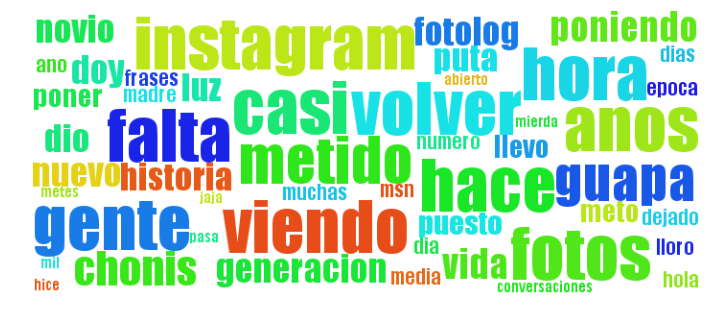

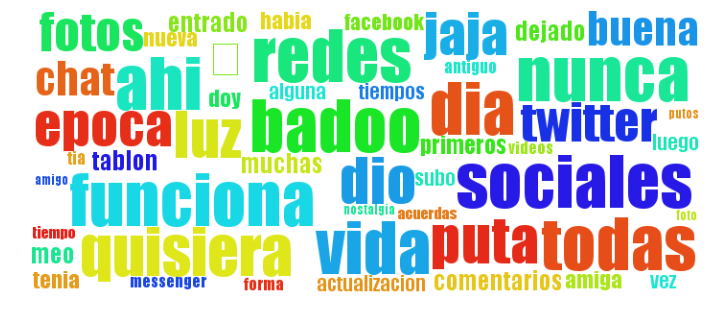

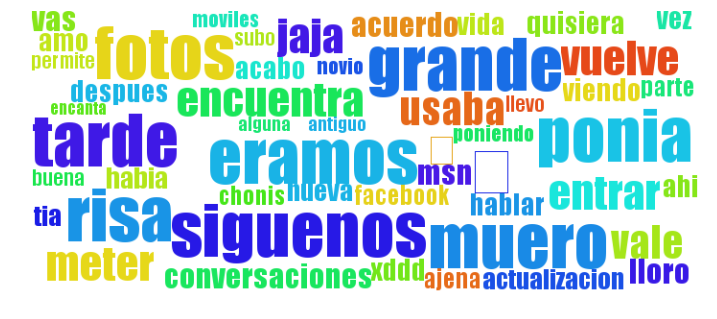

In [378]:
plot_topic_wordclouds(models[10], wordlist)

In [377]:
print_terms(models[10], wordlist)

  0: vete casa olvida line cara nombre insta facebook twitter vas
  1: mira empezo mismo acabo usaba vale meter acuerdo whatsapp muerto
  2: facebook sigue caido twitter chica redes haciendo mierda ir gusta
  3: face visto deberia ayer haber foto insta alguna antiguo subo
  4: madrid proximity trabajar comienza sigo dejar md fav mensaje vez
  5: pues verguenza horas hecho tiempo xd sera nuevo recuerdos red
  6: persona google buenos myspace dar dias nivel conoce cuenta facebook
  7: hace falta hora instagram fotos gente viendo casi anos volver
  8: sociales ahi funciona nunca redes dia todas badoo vida quisiera
  9: muero eramos grande tarde risa 😂 fotos siguenos ponia encuentra


In [379]:
Counter(np.argmax(models[10]['V_T'], axis=1))

Counter({0: 2, 1: 15, 2: 26, 3: 5, 4: 5, 5: 17, 6: 27, 7: 27, 8: 27, 9: 18})

In [213]:
print('\n---\n'.join(x for x in get_tweets(models[10], 8, docs_df)['text'].drop_duplicates(inplace=False)))

voy a meterme a mi tuenti a ver que me encuentro
---
@CristinaPrez2 tuenti jajaja
---
RT @_LuisCb97: Me encanta mirar el Tuenti de vez en cuando
---
@levsad la época tuenti nos dio la puta vida, posdata tengo fotos comprometedoras tuyas, un día saldrán a la luz
---
RT @FranciscodPaula: Nunca entenderé los continuos cambios en las Redes Sociales. Si funciona, para que lo tocas! Ahí tenemos el ejemplo de…
---
Me encanta mirar el Tuenti de vez en cuando
---
¿Por qué todas las redes sociales como tuenti y ahora Twitter acaban copiando a Facebook?
---
Esto me recuerda a la actualizacion de tuenti que fue el declive absoluto de su existencia
---
@IreneMartinez98 JAJAJAJAJAJA si quisiera joderte la vida buscaría en tuenti ahí sí que hay material 😂😂
---
Que Perea abandona twitter el día 31!! Y todas las Redes Sociales. El tuenti, el badoo...

Sus asesores mandan.

 https://t.co/foPSYAqMqS
---
RT @mariiazpt: @alitorralba_ tia q en la nueva actualización en vez de estrellas hay corazones como en

In [170]:
words = np.argsort(-1*components, axis=1)[:,:30]

NameError: name 'components' is not defined

In [255]:
ax.set_aspect

<bound method AxesSubplot.set_aspect of <matplotlib.axes._subplots.AxesSubplot object at 0x7f008ab865f8>>

/home/felipefg/.virtualenvs/analysis_py34/lib/python3.4/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


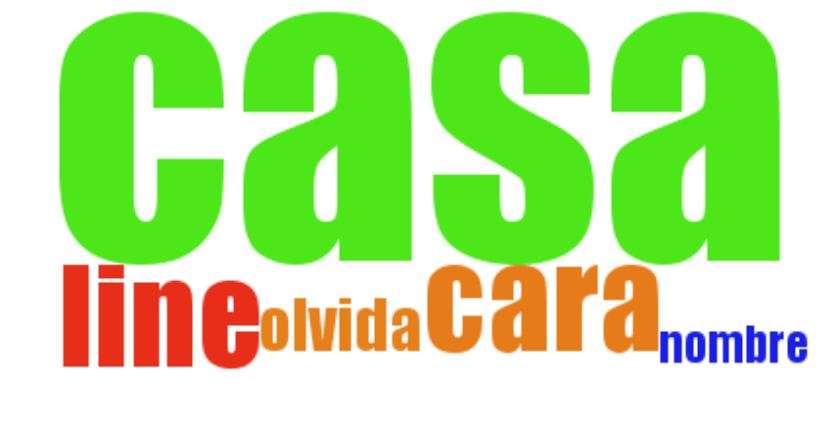

In [256]:
wc_generated = plot_wordcloud(
    [
        ('casa', 3),
        ('cara', 2),
        ('line', 2),
        ('olvida', 2),
        ('nombre', 1)
    ]
)

/home/felipefg/.virtualenvs/analysis_py34/lib/python3.4/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


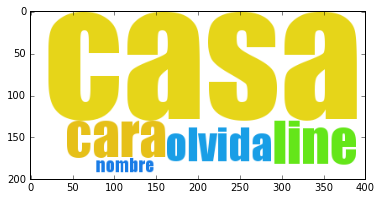

In [234]:
plt.imshow(wc_generated)

In [146]:
np_wordlist = np.array(wordlist)

In [147]:
np_wordlist[words].tolist()

NameError: name 'words' is not defined

In [1]:
def coherence_norm(data, tf_idf_norm):
    clusters = np.argmax(data['V_T'], axis=1)
    n_clusters = data['V_T'].shape[1]
    
    clusters_norm = []
    clusters_size = []
    coherence_cluster = []
    
    for idx_cluster in range(n_clusters):
        
        cluster_data = tf_idf_norm[clusters == idx_cluster]
        avg_vector = np.average(cluster_data, axis=0)
        cluster_norm = np.sqrt(np.power(avg_vector, 2).sum())
        clusters_norm.append(cluster_norm)
        clusters_size.append(cluster_data.shape[0])
        
        if cluster_data.shape[0] > 3:
            coherence_cluster.append(cluster_norm)
    
    
    data['avg_clusters_norm'] = clusters_norm
    data['clusters_size'] = clusters_size
    data['coherence_norm'] = np.average(clusters_norm)
    return np.average(coherence_cluster), np.std(clusters_norm)

In [195]:
for key in sorted(models.keys()):
    coherence_norm(models[key], doc_mat_norm)

In [196]:
data_x = sorted(models.keys())
data_ncut = [models[x]["n_cut"]/x for x in data_x]
data_coh = [models[x]["coherence_norm"] for x in data_x]

hover = bokeh.models.HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x, y)", "($x, $y)"),        ]
    )


plot = bokeh.plotting.figure(
    title="Ncut vs Coherence",
    plot_height=500, plot_width=900,
    tools=[hover, bokeh.models.ResizeTool(), bokeh.models.PanTool(), bokeh.models.WheelZoomTool()])

plot.line(data_x, data_ncut, color="#2222aa", line_width=2)
#plot.circle(data_x, data_ncut, color="#2222aa", fill_color="white", size=8)

plot.extra_y_ranges = {"coherence": bokeh.models.Range1d(start=0.0, end=1.0)}
plot.line(data_x, data_coh, line_width=2, color="red", y_range_name="coherence")
plot.add_layout(bokeh.models.LinearAxis(y_range_name="coherence"), 'right')

bokeh.plotting.show(plot)

In [151]:
data_x = sorted(models.keys())
data_ncut = [models[x]["n_cut"]/x for x in data_x]
data_coh = [models[x]["coherence_norm"] for x in data_x]

hover = bokeh.models.HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x, y)", "($x, $y)"),        ]
    )


plot = bokeh.plotting.figure(
    title="Ncut vs Coherence",
    plot_height=500, plot_width=900,
    tools=[hover, bokeh.models.ResizeTool(), bokeh.models.PanTool(), bokeh.models.WheelZoomTool()])


plot.circle(data_coh, data_ncut, color="#2222aa", size=4)
plot.xaxis.axis_label = "Coherence"
plot.yaxis.axis_label = "Ncut"

bokeh.plotting.show(plot)